# ◇ 라이브러리 설정 MNIST, numpy

In [194]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt
from collections import OrderedDict

# ◇ 계층 클래스 Affine
#### Affine클래스는 해당 부분을 저장
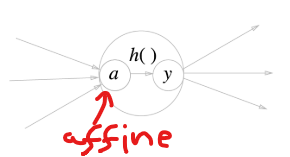

In [195]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x, flg):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        #print(self.x.shape, self.W.shape)
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

# ◇ 활성화 함수 Relu, softmax
# ◇ 손실 함수 cross_entropy_error (교차 엔트로피 오차)
# ◇ 수치미분-기울기 numerical_gradient
# ◇ 출력층 클래스 -> 소프트맥스, 손실 함수 값을 계산-저장 SoftmaxWithLoss

----
#### class Relu는 해당 부분을 저장
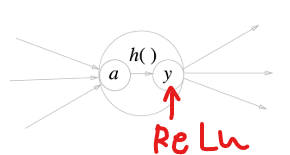

In [196]:
# Relu 활성화 함수 순전파, 역전파를 저장하는 클래스
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x, flg):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [197]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [198]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [199]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [200]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# ◇ 최적화 함수 SGD, Momentum, AdaGrad

In [201]:
class SGD:
    def __init__(self, Ir=0.01):
        self.Ir =Ir

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.Ir * grads[key]

In [202]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [203]:
class AdaGrad:
    def __init__ (self, Ir=0.01):
        self.Ir =Ir
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.Ir * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


# ◇ 학습 자료에 있는 배치 정규화 코드

In [204]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma=1, beta=0, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# ◇ 가중치 초기화 He

In [215]:
def He_init(input, ouput):
    return np.sqrt(1.5 / input) * np.random.randn(input, ouput)

# ◇ 다층 신경망 클래스

In [216]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.maxIndex = len(hidden_size)
        print("\n\n신경망 학습 시작 - 신경망: %d층"%(self.maxIndex+1))
        
        self.params = {}        
        self.params['W1'] = He_init(input_size, hidden_size[0])
        self.params['b1'] = np.zeros(hidden_size[0])

        #print(self.params['W1'].shape)

        for i in range(1, self.maxIndex):
            self.params['W' + str(i+1)] = He_init(hidden_size[i-1], hidden_size[i]) 
            self.params['b' + str(i+1)] = np.zeros(hidden_size[i])
            #print(self.params['W'  + str(i+1)].shape)

        self.params['W' + str(self.maxIndex)] = He_init(hidden_size[self.maxIndex - 1], output_size) 
        self.params['b' + str(self.maxIndex)] = np.zeros(output_size)
        #print(self.params['W' + str(self.maxIndex)].shape)

        # 계층 생성
        self.layers = OrderedDict()
        
        for i in range(1, self.maxIndex):
            self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])
            self.layers['BatchNormalization' + str(i)] = BatchNormalization()
            self.layers['Relu' + str(i)] = Relu()
    
        self.layers['Affine' + str(self.maxIndex)] = Affine(self.params['W' + str(self.maxIndex)], self.params['b' + str(self.maxIndex)])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x, train_flg=True):
        for layer in self.layers.values():
            x = layer.forward(x, train_flg)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x, False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}

        for i in range(1, self.maxIndex+1):
            grads['W' + str(i)] = numerical_gradient(loss_W, self.params['W' + str(i)])
            grads['b' + str(i)] = numerical_gradient(loss_W, self.params['b' + str(i)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        # 계층 레이어의 값을 리스트로 변환하여 가져옴 -> 해당 리스트를 거꾸로 정렬 -> 순서대로 계층의 역전파를 실행
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 기울기
        grads = {}
        for i in range(1, self.maxIndex+1):
            grads['W' + str(i)], grads['b' + str(i)] = self.layers['Affine' + str(i)].dW, self.layers['Affine' + str(i)].db
        
        return grads


# ◇ MNIST 불러오기

In [217]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

----
# 과제) 신경망 학습 코드 작성 시 발생한 문제와 해결 내용
<br/>

### 1) 기존 가중치 업데이트 방식 가중치 - (학습률*기울기) / 해당 방법으로 업데이트 시 학습이 잘 안됨
#### &emsp;&emsp;&emsp;--> 해결방법 : SGD, 모멘텀, AdaGrad를 사용해서 적절한 기울기 업데이트 방법을 사용하니 학습이 잘되는 것을 확인
<br/>

### 2) 2층 신경망에서는 학습에 문제가 없었으나 4층으로 늘릴 시 학습이 안되는 문제가 발생
#### &emsp;&emsp;&emsp;--> 해결방법 : 초기화 방법을 변경 / ReLu함수의 가중치 초기화를  He초기화(He_init 함수)로 하니 정상적으로 학습이 가능함
#### &emsp;&emsp;&emsp;&emsp;&emsp; 이후 층을 늘려도 학습이 되는 것을 확인
<br/>

### 3) 초기값, 모멘텀, SGD 등을 통해 어느정도 학습은 가능하나 일정 수준 이상으로 학습이 되지 않음
#### &emsp;&emsp;&emsp;--> 해결방법 : 교제에 나온 배치치 정규화를 시도
<br/>


# ◇ 학습 알고리즘 
<br />

## 계산 과정
1. TwoLayerNet클래스로 가중치 초기화 밑 신경망 구조를 설정 (hidden_size을 리스트로 보내어 좀 더 간단하게 층과 노드를 설정)
2. 횟수는 1만번 진행하며, 하이퍼피라미터를 수정
3. 배치 사이즈만큼 학습, 시험 데이터를 TwoLayerNet.gradient 으로 보내어 기울기를 구한다
- - 1. loss함수에서 predict함수를 호출하여 순전파를 진행한다 (OrderedDict으로 순서가 있는 딕셔너리를 통해 입력층부터 계산)
    2. predict함수는 출력층 전까지 값을 리턴한 후 loss함수에서 SoftmaxWithLoss클래스에 소프트맥스값, 교차 엔트로피 오차(손실)값을 설정한다.
    3. 2번에서 설정한 SoftmaxWithLoss클래스를 역전파를 하고, OrderedDict를 리스트로 변환하여 거꾸로 정렬, 순서대로 Affine, ReLu클래스의 역전파를 실행
    4. 역전파를 통해 각 Affine클래스에 저장된 dw, db값을 grads에 저장한 후 리턴
4. 구한 기울기를 SGD, Momentum, AdaGrad 중 1개를 이용하여 기존 기울기에 업데이트를 진행

## 하이퍼피라미터
- #### iters_num : 반복 횟수 = **10,000 고정**
- #### batch_size : 배치 사이즈 = **100~n?**
- #### hidden_size : 은닉층 노드 수 = **5 ~ 15**
- #### learning_rate : 학습률 = **0.001 ~ 0.019**

In [231]:
# 100, [15, 15, 15], 0.011

# 287, [15, 15, 15, 15, 15], 0.015


iters_num = 10000
batch_size = 500
#hidden_size = 15 
hidden_size = [15, 15, 15, 15, 15]
learning_rate = 0.015

# 기울기 최적화 함수들
sgd = SGD()
momentum = Momentum()
adaGrad = AdaGrad()

train_loss_list = []
train_acc_list = []
test_acc_list = []

train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=hidden_size, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식
    
    # 일반 갱신
    #for key in ('W1', 'b1', 'W2', 'b2'): network.params[key] -= learning_rate * grad[key]
        
    # SGD 학습, 모멘텀 학습, AdaGrad 학습
    #sgd.update(network.params, grad)
    momentum.update(network.params, grad)
    #adaGrad.update(network.params, grad)
    
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("%2d 번째 학습(에폭) --> train_acc : %.2f%%, test_acc : %.2f%%" % (len(train_acc_list), train_acc*100, test_acc*100))
        
print("최종 학습률 --> train_acc : %.2f%%, test_acc : %.2f%%" % (train_acc_list[-1]*100, test_acc_list[-1]*100))



신경망 학습 시작 - 신경망: 6층
 1 번째 학습(에폭) --> train_acc : 6.88%, test_acc : 6.83%
 2 번째 학습(에폭) --> train_acc : 82.59%, test_acc : 82.69%
 3 번째 학습(에폭) --> train_acc : 90.62%, test_acc : 90.41%
 4 번째 학습(에폭) --> train_acc : 92.36%, test_acc : 92.26%
 5 번째 학습(에폭) --> train_acc : 93.39%, test_acc : 93.09%
 6 번째 학습(에폭) --> train_acc : 93.88%, test_acc : 93.32%
 7 번째 학습(에폭) --> train_acc : 94.32%, test_acc : 93.62%
 8 번째 학습(에폭) --> train_acc : 94.64%, test_acc : 93.76%
 9 번째 학습(에폭) --> train_acc : 94.98%, test_acc : 94.06%
10 번째 학습(에폭) --> train_acc : 95.08%, test_acc : 94.07%
11 번째 학습(에폭) --> train_acc : 95.30%, test_acc : 94.32%
12 번째 학습(에폭) --> train_acc : 95.55%, test_acc : 94.45%
13 번째 학습(에폭) --> train_acc : 95.69%, test_acc : 94.57%
14 번째 학습(에폭) --> train_acc : 95.84%, test_acc : 94.61%
15 번째 학습(에폭) --> train_acc : 96.00%, test_acc : 94.79%
16 번째 학습(에폭) --> train_acc : 96.09%, test_acc : 94.67%
17 번째 학습(에폭) --> train_acc : 96.18%, test_acc : 94.89%
18 번째 학습(에폭) --> train_acc : 96.28%, test_acc

----

# 학습 그래프

In [249]:
import matplotlib.pyplot as plt
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

### 반복횟수와 손실함수값 추이 (Momentum) ▽

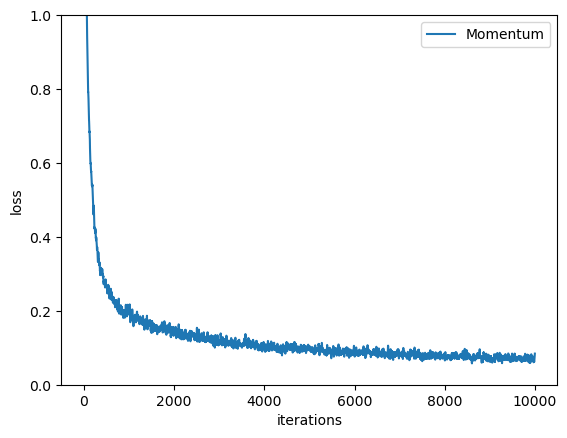

In [250]:
# 손실 함수 값
x = np.arange(len(train_loss_list))
plt.plot(x, smooth_curve(train_loss_list), label='Momentum')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 에폭 당 정확도 변화 ▽

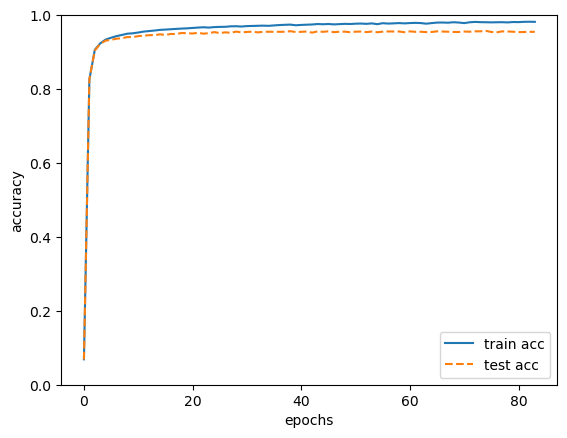

In [251]:
# 에폭 당 정확도
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()